In [1]:
# Imports
import os
import string
import unicodedata

from typing import Generator

# Packages
import pandas as pd
from sklearn.externals import joblib

# Project imports
from rcare.sqlutils import SqlUtils
from rcare.readutils import DataFrameUtils as Utils
import logging
logging.basicConfig(format='%(module)s||%(funcName)s||[%(process)d:%(thread)d||%(asctime)s||%(levelname)s||%(message)s', level=logging.INFO,
                    datefmt=logging.Formatter.default_time_format)

#SECTION_SEGMENTER_MODEL = joblib.load(os.path.join("lexnlp/nlp/en/segments/", "./section_segmenter_rcare.pickle"))
#from lexnlp.nlp.en.segments.sections import get_sections;
#from lexnlp.nlp.en.segments.pages import get_pages;
#DATA_PATH = 'data/lexpredict-contraxsuite-samples/cca_2011_Q3/text/'
DATA_PATH = '../sqllite-node/app/data/'
#print(os.listdir(DATA_PATH))

import numpy as np
import  sqlite3
connex  =  sqlite3.connect(DATA_PATH + "/training.db") # Opens file if exists, else creates file

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


#CLF_MODEL = joblib.load(os.path.join("lexnlp/nlp/en/segments/", "./section_segmenter_rcare.pickle"))


In [3]:
df_sql = pd.read_sql_query(sql="select tf.* from training_features tf join meta_data md \
                    on md.txtFileName = tf.name and md.useForTraining = 1 and md.grp = 'citi_JL' ",\
                           con=connex, chunksize = 10000)
#df_sql.describe()
df = []
train_df = []
test_df = []
score_df = []
idx = 0
train = []
target = []
debug_columns =  ['debug','name',  'line_id']


In [4]:
logging.info("Loading Training data to memory")    
combined_df = pd.DataFrame()

for test_feature_df in df_sql:
    
    logging.info("********************************")
    logging.info("Index : %d", idx);  
    
    idx = idx + 1
    combined_df = pd.concat([combined_df, test_feature_df], ignore_index  = True)
        
logging.info("Loading Training data complete")    


combined_df.describe()

<ipython-input-4-beab22a9bc5a>||<module>||[6075:140454043100928||2018-09-12 10:36:11||INFO||Loading Training data to memory
<ipython-input-4-beab22a9bc5a>||<module>||[6075:140454043100928||2018-09-12 10:36:12||INFO||********************************
<ipython-input-4-beab22a9bc5a>||<module>||[6075:140454043100928||2018-09-12 10:36:12||INFO||Index : 0
<ipython-input-4-beab22a9bc5a>||<module>||[6075:140454043100928||2018-09-12 10:36:12||INFO||Loading Training data complete


,line_0_token_is_alpha_0,line_0_token_is_alpha_1,line_0_token_is_alpha_2,line_0_token_is_alpha_3,line_0_token_is_alpha_4,line_0_token_is_alpha_n_1,line_0_token_is_alpha_n_2,line_0_token_is_cardinal_0,line_0_token_is_cardinal_1,line_0_token_is_cardinal_2,...,sent_tcase_tcount_2,sent_tcount_0,sent_tcount_1,sent_tcount_2,sent_ucase_tcount_0,sent_ucase_tcount_1,sent_ucase_tcount_2,line_is_start_of_sent_0,line_is_end_of_sent_0,target
count,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,...,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000
mean,0.266868,0.314199,0.196375,0.287009,0.324270,0.217523,0.356495,0.223565,0.223565,0.131923,...,0.429003,11.349446,5.751762,4.450151,0.454179,0.117825,0.155086,0.409869,0.409869,0.049345
std,0.442434,0.464313,0.397355,0.452480,0.468219,0.412665,0.479085,0.416739,0.416739,0.338493,...,1.772799,21.085594,15.564874,13.042607,2.167812,0.829685,1.928212,0.491933,0.491933,0.216643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,17.000000,181.000000,148.000000,115.000000,29.000000,12.000000,40.000000,1.000000,1.000000,1.000000


In [5]:
#df[len(df) -1]

    #combined_df.info()
logging.info("Splitting training & test sets..")       
percentage = 100
df_min = 0
df_max = int(len(combined_df) * percentage/100)
debug_columns =  ['debug','name',  'line_id','target']
Y = combined_df[debug_columns]
X = combined_df.drop(columns=debug_columns)

X_train, X_test, y_train, y_test = train_test_split(X[df_min:df_max].values , Y[df_min:df_max].target.values , test_size=0.30, random_state=None)


#combined_df = combined_df.join(debug_df)
#clf.fit(X_train, y_train)
#feature_imp_df = pd.DataFrame({'feature':combined_df.drop(columns=debug_columns).columns.values, 'feature_importance':clf.feature_importances_,})
#score = clf.score(X_test, y_test)
    
    #df.append(test_feature_df)
print (X_train.shape)
print (X_test.shape)
logging.info("Splitting training & test complete")       


<ipython-input-5-801b0970aca0>||<module>||[6075:140454043100928||2018-09-12 10:36:23||INFO||Splitting training & test sets..
<ipython-input-5-801b0970aca0>||<module>||[6075:140454043100928||2018-09-12 10:36:23||INFO||Splitting training & test complete


(1390, 769)
(596, 769)


In [ ]:
clf = DecisionTreeClassifier(random_state=21)
clf.fit(X_train, y_train)

In [ ]:
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
#score, clf.feature_importances_
print (score)
cm = confusion_matrix(y_test, y_pred)
print (cm)


In [ ]:
#clf.feature_importances_
#combined_df = combined_df.join(debug_df)
feature_imp_df = pd.DataFrame({
    'feature':X.columns.values, 
    #'feature':combined_df.drop(columns=debug_columns).columns.values, 
                                   'feature_importance':clf.feature_importances_,})
feature_imp_df.query("feature_importance > .0")
#feature_imp_df

In [ ]:
#clf.feature_importances_ , clf.n_features_ , clf.classes_ , clf.max_features_ , 
import pickle
decision_tree_pkl_filename = "rcare/nlp/section_segmenter_dt.pickle"
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(clf, decision_tree_model_pkl)
#os.path.join("lexnlp/nlp/en/segments/", "section_segmenter_rcare.pickle")

In [ ]:
X_train.shape[1], int(X_train.shape[1]/2), int(X_train.shape[1] * (2 /3)) , 

In [6]:
def error(predictions, y):
    real = y.ravel()
    total = np.shape(predictions)[0]
    correct = np.sum(predictions == real)
    return 1 - (correct / total)

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
training_errors = []
validation_errors = []
accuracy_scores = []
smallest_validation_error = np.inf
best_classifier = None

scaler = StandardScaler()  
# Don't cheat - fit only on training data
#X_train = scaler.fit(X_train)  

X_train_mlp = scaler.fit_transform(X_train)  
X_test_mlp = scaler.fit_transform(X_test)  



#test = pd.DataFrame(X_train)
#test.describe()
#LAMBDAS = [1e-5, 1e-3, 1e-1, 1, 3, 10, 30]
LAMBDAS = [1e-5]
#hidden_layer_sizes=(int(X_train.shape[1] * (2 /3),int(X_train.shape[1] * (2 /3)  )
#hidden_layer_sizes=(600,200)
hidden_layer_sizes = (X_train.shape[1], )

for LAMBDA in LAMBDAS:
    clf_m = MLPClassifier(  hidden_layer_sizes=hidden_layer_sizes, alpha=LAMBDA, \
                        verbose=True, max_iter=5000, random_state=21,tol=0.000001)
    clf_m.fit(X_train_mlp, y_train)
    
    pred_train = clf_m.predict(X_train_mlp)    
    err_train = error(pred_train, y_train)
    training_errors.append(err_train)
    
    pred_val = clf_m.predict(X_test_mlp)    
    err_val = error(y_test, pred_val)
    validation_errors.append(err_val)
    
    accuracy_scores.append(accuracy_score(y_test, pred_val))
    
    if err_val < smallest_validation_error:
        best_classifier = clf_m
        smallest_validation_error = err_val
    

y_pred = best_classifier.predict(X_test_mlp)    
accuracy_score(y_test, y_pred)
#[coef.shape for coef in clf.coefs_]


Iteration 1, loss = 0.27488884
Iteration 2, loss = 0.01334407
Iteration 3, loss = 0.00359600
Iteration 4, loss = 0.00156022
Iteration 5, loss = 0.00091203
Iteration 6, loss = 0.00063218
Iteration 7, loss = 0.00051087
Iteration 8, loss = 0.00044794
Iteration 9, loss = 0.00040323
Iteration 10, loss = 0.00037320
Iteration 11, loss = 0.00034620
Iteration 12, loss = 0.00032760
Iteration 13, loss = 0.00030933
Iteration 14, loss = 0.00029329
Iteration 15, loss = 0.00027965
Iteration 16, loss = 0.00026718
Iteration 17, loss = 0.00025520
Iteration 18, loss = 0.00024503
Iteration 19, loss = 0.00023475
Iteration 20, loss = 0.00022586
Iteration 21, loss = 0.00021704
Iteration 22, loss = 0.00020902
Iteration 23, loss = 0.00020172
Iteration 24, loss = 0.00019475
Iteration 25, loss = 0.00018833
Iteration 26, loss = 0.00018224
Iteration 27, loss = 0.00017625
Iteration 28, loss = 0.00017097
Iteration 29, loss = 0.00016599
Iteration 30, loss = 0.00016094
Iteration 31, loss = 0.00015613
Iteration 32, los

0.9916107382550335

[(769, 769), (769, 1)]
[[570   3]
 [  2  21]]


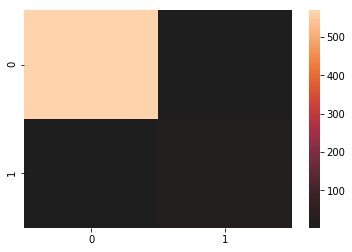

'\n[[14466   249]\n [  346  1651]]\n'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
print([coef.shape for coef in best_classifier.coefs_])
cm = confusion_matrix(y_test, y_pred)
print (cm)
sns.heatmap(cm, center=False)
plt.show()
'''
[[14466   249]
 [  346  1651]]
'''

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
LAMBDA_idx = 10
#print("Validation error when lambda = 10:", validation_errors[LAMBDAS.index(LAMBDA_idx)])

plt.figure()
plt.plot(LAMBDAS, training_errors, label="Training error")
plt.plot(LAMBDAS, validation_errors, label="Validation error")
#plt.plot(LAMBDAS, accuracy_scores, label="Accuracy Scores")
plt.legend()
plt.xscale('log')
plt.axvline(LAMBDA_idx, color='red', linestyle=":")
plt.show()

In [ ]:
import pickle
mlp_pkl_filename = "rcare/nlp/section_segmenter_mlp.pickle"
mlp_model_pkl = open(mlp_pkl_filename, 'wb')
pickle.dump(best_classifier, mlp_model_pkl)

In [ ]:
validation_errors

In [ ]:
training_errors

In [ ]:
accuracy_scores

In [ ]:
best_classifier

In [ ]:
LAMBDAS

In [ ]:
combined_df.query("name=='creditcardagreement_118.TXT' and target > 0")\
[['debug','line_id','target']]

In [ ]:
X_train.shape[1]

In [ ]:
(combined_df.dtypes != 'float').values

In [ ]:
combined_df.columns[(combined_df.dtypes != 'float').values].values

In [ ]:
SECTION_SEGMENTER_MODEL = joblib.load("rcare/nlp/section_segmenter_mlp.pickle")
SECTION_SEGMENTER_MODEL

In [ ]:
best_classifier.intercepts_     

In [ ]:
combined_df.query("name == 'creditcardagreement_1182.TXT'")[['line_id','debug', 'target']]

In [8]:
combined_df[:1000]

,debug,line_0_token_is_alpha_0,line_0_token_is_alpha_1,line_0_token_is_alpha_2,line_0_token_is_alpha_3,line_0_token_is_alpha_4,line_0_token_is_alpha_n_1,line_0_token_is_alpha_n_2,line_0_token_is_cardinal_0,line_0_token_is_cardinal_1,...,sent_tcase_tcount_2,sent_tcount_0,sent_tcount_1,sent_tcount_2,sent_ucase_tcount_0,sent_ucase_tcount_1,sent_ucase_tcount_2,line_is_start_of_sent_0,line_is_end_of_sent_0,target
0,DATE OF BIRTH,1,1,1,0,0,1,1,0,0,...,0,3,1,1,3,0,0,1,0,0
1,BORROWER'S NAME AND ADDRESS,1,0,1,1,1,1,1,0,0,...,0,5,1,1,5,0,0,0,0,0
2,CO-BORROWER'S NAME AND ADDRESS,1,0,1,0,1,1,1,0,0,...,0,7,1,1,6,0,0,0,0,0
3,ACCOUNT NUMBER,1,1,0,0,0,1,1,0,0,...,0,2,1,1,2,0,0,0,0,0
4,DATE OF BIRTH,1,1,1,0,0,1,1,0,0,...,0,3,1,1,3,0,0,0,0,0
5,LASER IA FI14086 1-2010,1,1,0,0,0,0,0,0,0,...,0,6,1,1,3,0,0,0,0,0
6,CREDIT CARD AGREEMENT,1,1,1,0,0,1,1,0,0,...,0,3,1,1,3,0,0,0,0,0
7,page 1 of 4 COPYRIGHT 2006 Securian Financial ...,1,0,1,0,1,0,1,0,0,...,0,11,4,1,1,0,0,0,0,0
8,1630 King Street,0,1,1,0,0,1,1,0,0,...,0,3,1,1,0,0,0,0,0,0
9,"Alexandria, VA 22314-2745",1,0,1,0,0,0,0,0,0,...,0,6,1,1,1,0,0,0,0,0


In [28]:
from rcare.es_helper import ESHelper
ES_CONFIG = {
    "host": [
        {
            "host": "localhost",                  
            "port":"9200"
        }
    ],
    "log": "error"
};



def get_id(item):
    return "{}_{}".format(item['name'] ,str(item['line_id']))


esHelper = ESHelper(ES_CONFIG)



In [42]:
step =  1000
loop = [(i, i + step) for i in range(0, combined_df['debug'].count() + 1,step)]
loop

[(0, 1000),
 (1000, 2000),
 (2000, 3000),
 (3000, 4000),
 (4000, 5000),
 (5000, 6000),
 (6000, 7000),
 (7000, 8000),
 (8000, 9000),
 (9000, 10000),
 (10000, 11000),
 (11000, 12000),
 (12000, 13000),
 (13000, 14000),
 (14000, 15000),
 (15000, 16000),
 (16000, 17000),
 (17000, 18000),
 (18000, 19000),
 (19000, 20000),
 (20000, 21000),
 (21000, 22000),
 (22000, 23000),
 (23000, 24000),
 (24000, 25000),
 (25000, 26000),
 (26000, 27000),
 (27000, 28000),
 (28000, 29000),
 (29000, 30000),
 (30000, 31000),
 (31000, 32000),
 (32000, 33000),
 (33000, 34000),
 (34000, 35000),
 (35000, 36000),
 (36000, 37000),
 (37000, 38000),
 (38000, 39000),
 (39000, 40000),
 (40000, 41000),
 (41000, 42000),
 (42000, 43000),
 (43000, 44000),
 (44000, 45000),
 (45000, 46000),
 (46000, 47000),
 (47000, 48000),
 (48000, 49000),
 (49000, 50000),
 (50000, 51000),
 (51000, 52000),
 (52000, 53000),
 (53000, 54000),
 (54000, 55000),
 (55000, 56000),
 (56000, 57000)]

In [43]:
for start, end in loop:
    print(start, end)
    esHelper.bulk_stream_collection( combined_df[start:end].to_dict(orient='records'), 
                        index = "segmentation", doc_type = "training_features",  get_id = get_id)


0 1000


retry||from_int||[21259:140192005080832||2018-09-05 16:45:07||DEBUG||Converted retries value: False -> Retry(total=False, connect=None, read=None, redirect=0, status=None)
connectionpool||_new_conn||[21259:140192005080832||2018-09-05 16:45:07||DEBUG||Starting new HTTP connection (7): localhost:9200
connectionpool||_make_request||[21259:140192005080832||2018-09-05 16:45:08||DEBUG||http://localhost:9200 "POST /_bulk HTTP/1.1" 200 97317
base||log_request_success||[21259:140192005080832||2018-09-05 16:45:08||INFO||POST http://localhost:9200/_bulk [status:200 request:0.628s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

base||log_request_success||[21259:140192005080832||2018-09-05 16:45:09||DEBUG||< {"took":202,"e

retry||from_int||[21259:140192005080832||2018-09-05 16:45:09||DEBUG||Converted retries value: False -> Retry(total=False, connect=None, read=None, redirect=0, status=None)
connectionpool||_make_request||[21259:140192005080832||2018-09-05 16:45:10||DEBUG||http://localhost:9200 "POST /_bulk HTTP/1.1" 200 97427
base||log_request_success||[21259:140192005080832||2018-09-05 16:45:10||INFO||POST http://localhost:9200/_bulk [status:200 request:0.349s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

base||log_request_success||[21259:140192005080832||2018-09-05 16:45:10||DEBUG||< {"took":117,"errors":false,"items":[{"update":{"_index":"segmentation","_type":"training_features","_id":"creditcardagreement_117.TXT_100","_v

Success count: 1000, Failure count: 0
1000 2000


retry||from_int||[21259:140192005080832||2018-09-05 16:45:12||DEBUG||Converted retries value: False -> Retry(total=False, connect=None, read=None, redirect=0, status=None)
base||log_request_fail||[21259:140192005080832||2018-09-05 16:45:22||WARNING||POST http://localhost:9200/_bulk [status:N/A request:10.016s]
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/en-nlp/lib/python3.6/site-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/home/paperspace/anaconda3/envs/en-nlp/lib/python3.6/site-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/home/paperspace/anaconda3/envs/en-nlp/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/home/paperspace/anaconda3/envs/en-nlp/lib/python3.6/http/client.py", line 297, in begin
    version, status, reason = self._read_status()
  File "/h

ConnectionTimeout: ConnectionTimeout caused by - ReadTimeoutError(HTTPConnectionPool(host='localhost', port='9200'): Read timed out. (read timeout=10))

In [45]:
combined_df.columns[0]


'debug'